In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-3.5-turbo")


In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


The first thing you do when you define a graph is define the State of the graph. 


In [3]:
# The State consists of the schema of the graph as well as reducer functions which specify how to apply updates to the state. 
# In our example State is a TypedDict with a single key: messages. 
# The messages key is annotated with the add_messages reducer function, 
# which tells LangGraph to append new messages to the existing list, rather than overwriting it. 
# State keys without an annotation will be overwritten by each update, storing the most recent value. 
# Check out this conceptual guide to learn more about state, reducers and other low-level concepts.
# https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages

In [4]:
# 1) Define class State
#  - "State" is a dictionary that inherits from "TypedDict". 
#  - "TypedDict" is a way to define a dictionary with specific types for its keys and values in a more structured way.
# -  "messages" is a key in dictionary "State". The value for this key is a list and it uses "Annotated" type hint.
# -  "add_messages" is a function or a descriptor that specifies how the messages list should be updated 

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [5]:
#create an instance of a StateGraph using the State class as its argument.

graph_builder = StateGraph(State)

In [6]:

#So now our graph knows two things:

# Every node we define will receive the current State as input and return a value that updates that state.
# Messages will be appended to the current list, rather than directly overwritten. 
# This is communicated via the prebuilt add_messages function in the Annotated syntax.

Next, add a "chatbot" node. Nodes represent units of work. They are typically regular python functions.

In [7]:
#The function takes a single parameter named state.
#It takes the current state (represented by the state parameter) and processes it.
#The function returns a dictionary with a single key-value pair:
#The result of invoking llm.invoke(state["messages"]) is included in the "messages" list within the returned dictionary.


This chatbot node function takes the current State as input and returns an updated messages list. 

This is the basic pattern for all LangGraph node functions.

The add_messages function in our State will append the llm's response messages to whatever messages are already in the state.

In [8]:


# This is a node that we'll add to the graph

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.


In [9]:
graph_builder.add_node("chatbot", chatbot)


Next, add an entry point. This tells our graph where to start its work each time we run it.

Similarly, set a finish point. This instructs the graph "any time this node is run, you can exit."

In [10]:
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

Finally, we'll want to be able to run our graph. To do so, call "compile()" on the graph builder. This creates a "CompiledGraph" we can use invoke on our state.

In [11]:
graph = graph_builder.compile()

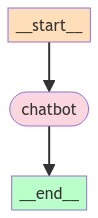

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: Hello! How can I assist you today?
Assistant: Langgraph is a platform that provides language learning resources and tools for individuals looking to improve their language skills. This includes interactive lessons, grammar guides, vocabulary lists, and language practice exercises. Users can choose from a variety of languages to learn, and track their progress as they work towards fluency. Langgraph aims to make language learning accessible, engaging, and effective for learners of all levels.
Goodbye!
